In [43]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle, Circle
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator


# PyROOT imports
#from ROOT import TTree, TFile -- cannot install ROOT using conda on Windows, using uproot instead

# SciKitHep imports
import uproot
import hist
import awkward as ak

In [2]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'family' : 'serif','weight' : 'normal','size'   : 22}
plt.rc('font', **font)

In [3]:
path_trit = 'ch3t_sr1_fixed.root'
path_bkg = 'bg_sr1_fixed.root'
SE_size = 47.07

In [4]:
trit = uproot.concatenate(f'{path_trit}:Events'
                         # filter_name=['runID','evtID']
                         )

bkg = uproot.concatenate(f'{path_bkg}:Events'
                         # filter_name=['runID','evtID']
                         )

In [19]:
# trit cuts
S2_size_es = trit.S2_corrected_area/SE_size

drift_cut = (65000 < trit.drift_time)& (trit.drift_time < 900000) 
horizontal_cut = (trit.evt_bad_area < 1420) & (S2_size_es < 70)
diagonal_cut = (trit.evt_bad_area < 6*S2_size_es + 1000) & (S2_size_es > 70)
S2_range_cut = ((5 < S2_size_es) & (S2_size_es < 500))
lower_cut = horizontal_cut | diagonal_cut
hs1_cut = (((trit.S2_x_cm+38)**2 + (trit.S2_y_cm-36)**2)**0.5 > 5)
hs2_cut = (((trit.S2_x_cm+23)**2 + (trit.S2_y_cm-8)**2)**0.5 > 3)
hs3_cut = (((trit.S2_x_cm-4)**2 + (trit.S2_y_cm-8)**2)**0.5 > 4)
hs4_cut = (((trit.S2_x_cm+3)**2 + (trit.S2_y_cm-8)**2)**0.5 > 2)
hs5_cut = (((trit.S2_x_cm+32)**2 + (trit.S2_y_cm+39)**2)**0.5 > 2)
hs6_cut = (((trit.S2_x_cm-19)**2 + (trit.S2_y_cm)**2)**0.5 > 2)
hs7_cut = (((trit.S2_x_cm-24)**2 + (trit.S2_y_cm+8)**2)**0.5 > 3)
hs_cut = hs1_cut & hs2_cut & hs3_cut & hs4_cut & hs5_cut & hs6_cut & hs7_cut

S2_range_cut = ((0 < trit.S1_corrected_area) & (trit.S1_corrected_area < 140))


trit_cut = hs_cut & S2_range_cut & lower_cut & drift_cut & S2_range_cut


In [20]:
# bkg cuts 

h1_centre = (-24,8)
h1_r = 4
h2_centre = (-3,8)
h2_r = 2.5
h3_centre = (4.2,8)
h3_r = 4
h4_centre = (-32.5,-39)
h4_r = 2

r1_cut = (((bkg.S2_x_cm-h1_centre[0])**2 + (bkg.S2_y_cm-h1_centre[1])**2)**0.5 > h1_r)
r2_cut = (((bkg.S2_x_cm-h2_centre[0])**2 + (bkg.S2_y_cm-h2_centre[1])**2)**0.5 > h2_r)
r3_cut = (((bkg.S2_x_cm-h3_centre[0])**2 + (bkg.S2_y_cm-h3_centre[1])**2)**0.5 > h3_r)
r4_cut = (((bkg.S2_x_cm-h4_centre[0])**2 + (bkg.S2_y_cm-h4_centre[1])**2)**0.5 > h4_r)
hotspot_cuts = (r1_cut & r2_cut & r3_cut & r4_cut)

s1_area_cut = ((0 < bkg.S1_corrected_area) & (bkg.S1_corrected_area < 140))

single_e_size = 47.07
s2_area_cut = ((5 < bkg.S2_corrected_area / single_e_size) & (bkg.S2_corrected_area / single_e_size < 500))

se_s2_cor_area = bkg.S2_corrected_area / single_e_size

str8_line_cut1 = ((bkg.evt_bad_area < 6 * 70 + 1000) & (se_s2_cor_area < 70))
str8_line_cut2 = ((bkg.evt_bad_area < 6 * se_s2_cor_area + 1000) & (se_s2_cor_area > 70))
badarea_cut = (str8_line_cut1|str8_line_cut2)

cath_cut = bkg.drift_time > 900000
gate_cut = bkg.drift_time < 10000

S2o_cut = (bkg.S1_corrected_area !=-999)

bkg_cath_cut = hotspot_cuts & s2_area_cut & badarea_cut & cath_cut & s1_area_cut & S2o_cut
bkg_gate_cut = hotspot_cuts & s2_area_cut & badarea_cut & gate_cut & s1_area_cut & S2o_cut

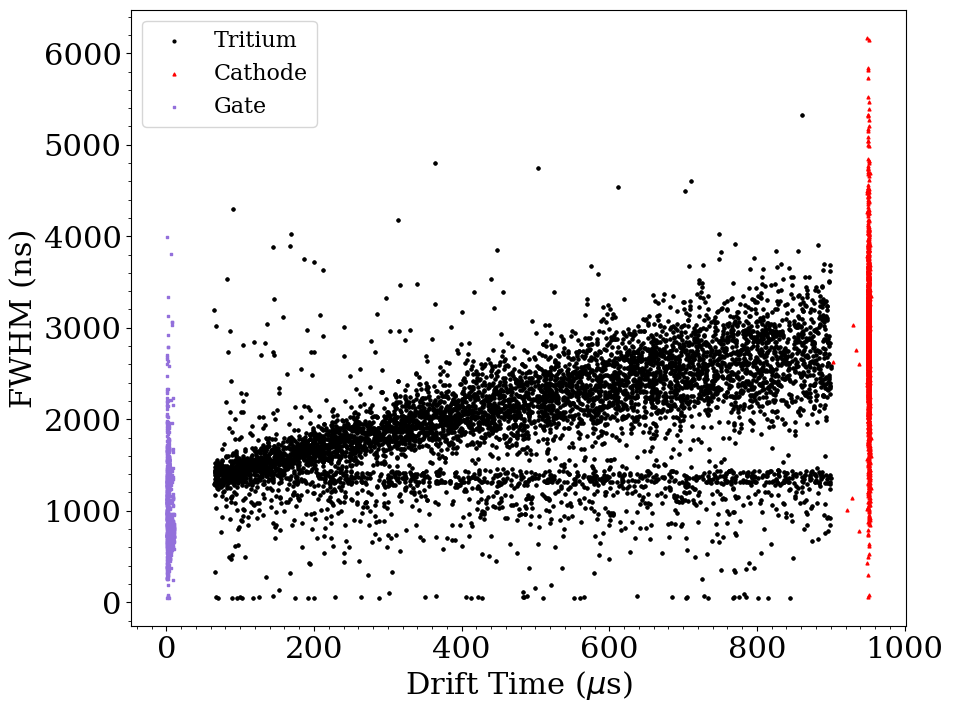

In [69]:
#for the a nice plot 
trit_max = trit.S2_fwhm_ns < 10000
cath_max = bkg.drift_time <= 1e6

fig,ax=plt.subplots()
ax.scatter(trit.drift_time[trit_cut&trit_max], trit.S2_fwhm_ns[trit_cut&trit_max], label='Tritium', color='black', marker='o',s=4)
ax.scatter(bkg.drift_time[bkg_cath_cut&cath_max], bkg.S2_fwhm_ns[bkg_cath_cut&cath_max],label='Cathode',color='red',marker='^',s=4)
ax.scatter(bkg.drift_time[bkg_gate_cut], bkg.S2_fwhm_ns[bkg_gate_cut],label='Gate',color='mediumpurple',marker='s',s=4)
#ax.fill_between(np.linspace(10e3,65e3,1000),np.zeros(1000),np.full(1000,6000),color='gray',alpha=0.2,label='Gas Event Region')
#ax.plot(np.full(1000,65000), np.linspace(0,6000,1000), linestyle='--',color='gray')
#ax.plot(np.full(1000,10000), np.linspace(0,6000,1000), linestyle='--',color='gray')

ax.legend(fontsize=16)
ax.set_ylabel('FWHM (ns)')
ax.set_xlabel(r'Drift Time ($\mu$s)')
ax.xaxis.set_minor_locator(MultipleLocator(0.2e5))
ax.yaxis.set_minor_locator(MultipleLocator(200))
ax.set_xticks(ticks=[0,0.2e6,0.4e6,0.6e6,0.8e6,1e6],labels=[0,200,400,600,800,1000])
plt.savefig('drift_width.svg')